## CNN

### 导入库函数

In [1]:
import pandas as pd
import torch
import os
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from PIL import Image
import scipy.io


### 预处理部分

In [2]:
dataset = pd.read_excel('./dataProcess/时序数据集10g_3.xlsx')
dataset = dataset[['时间戳', 'X', 'Y', 'Z', '负载','1号舵机', '2号舵机', '3号舵机', '4号舵机']]
dataset

,时间戳,X,Y,Z,负载,1号舵机,2号舵机,3号舵机,4号舵机
0,1693207477303,95.633377,100.861282,399.706055,10,2003,1870,2170,2052
1,1693207477402,94.762863,99.848640,399.830139,10,1994,1866,2170,2062
2,1693207477502,90.753143,95.100525,400.080658,10,1983,1862,2170,2072
3,1693207477603,86.134407,88.276474,400.020599,10,1973,1858,2170,2082
4,1693207477702,81.485260,80.654297,399.635773,10,1963,1854,2170,2092
...,...,...,...,...,...,...,...,...,...
51489,1693222130910,88.539680,106.831177,398.654358,10,2022,1879,2170,2059
51490,1693222131010,88.600815,101.826241,399.158173,10,2011,1875,2170,2059
51491,1693222131110,88.856209,96.868546,399.538696,10,2002,1871,2170,2060
51492,1693222131210,89.497528,91.901711,399.769196,10,1991,1871,2170,2060


In [3]:
dataset.iloc[:,:4]

,时间戳,X,Y,Z
0,1693207477303,95.633377,100.861282,399.706055
1,1693207477402,94.762863,99.848640,399.830139
2,1693207477502,90.753143,95.100525,400.080658
3,1693207477603,86.134407,88.276474,400.020599
4,1693207477702,81.485260,80.654297,399.635773
...,...,...,...,...
51489,1693222130910,88.539680,106.831177,398.654358
51490,1693222131010,88.600815,101.826241,399.158173
51491,1693222131110,88.856209,96.868546,399.538696
51492,1693222131210,89.497528,91.901711,399.769196


In [4]:
dataset.iloc[:,5:]

,1号舵机,2号舵机,3号舵机,4号舵机
0,2003,1870,2170,2052
1,1994,1866,2170,2062
2,1983,1862,2170,2072
3,1973,1858,2170,2082
4,1963,1854,2170,2092
...,...,...,...,...
51489,2022,1879,2170,2059
51490,2011,1875,2170,2059
51491,2002,1871,2170,2060
51492,1991,1871,2170,2060


In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,:5], dataset.iloc[:,5:], test_size=0.2, random_state=42)

## DataLoader pytorch 封装的数据

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


class MyDataset(Dataset):
    def __init__(self,mode = 'train'): #让我们初始化数据集的 读取外部文件
        dataset = pd.read_excel('./dataProcess/时序数据集10g_3.xlsx')
        dataset = dataset[['X', 'Y', 'Z', '负载','1号舵机', '2号舵机', '3号舵机', '4号舵机']]
        dataset = dataset.dropna()
        # 最小-最大归一化
        min_max_scaler = MinMaxScaler()
        dataset = min_max_scaler.fit_transform(dataset)
        dataset = pd.DataFrame(dataset,columns = ['X', 'Y', 'Z', '负载','1号舵机', '2号舵机', '3号舵机', '4号舵机'])
        X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,:4], dataset.iloc[:,4:], test_size=0.2, random_state=42)
        
        
        if mode == 'train':
            self.X, self.Y = X_train.values, y_train.values
        else:
            self.X, self.Y = X_test.values, y_test.values
            
    def __len__(self): #return 数据集大小
        return len(self.X)
    
    def __getitem__(self, index):# 取出一条数据 随机一个序号 在range（len）的范围内 必须给我特征+标签
        return np.array(self.X[index],np.float32),np.array(self.Y[index],np.float32) # 去读文件 才占内存
# Create DataLoader objects for the train and test sets
train_dataset = MyDataset(mode = 'train')
test_dataset = MyDataset(mode = 'test')
batch_size = 50
train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size = 20, shuffle=True)

In [7]:
for xx,yy in train_loader:
    print(xx.shape,yy.shape)
    break

torch.Size([50, 4]) torch.Size([50, 4])


### CNN模型搭建
```
输入的图片 经过模型 得到预测值 
[50, 1, 227, 227] -> Model > [50,1]
```

In [8]:
#迁移学习
from torchvision import models
import torch.nn as nn
import torch
class RNET(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNET, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.relu1 = nn.LeakyReLU(inplace=True)
        
        self.fc2 = nn.Linear(200, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.relu2 = nn.LeakyReLU(inplace=True)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.dp1 = nn.Dropout(0.1)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.relu3 = nn.LeakyReLU(inplace=True)
        
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.1)
        self.bn4 = nn.BatchNorm1d(hidden_dim)
        self.relu4 = nn.LeakyReLU(inplace=True)
        
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.dp3 = nn.Dropout(0.1)
        self.bn5 = nn.BatchNorm1d(hidden_dim)
        self.relu5 = nn.LeakyReLU(inplace=True)
        
        self.fc6 = nn.Linear(hidden_dim, output_dim)
        self.dp4 = nn.Dropout(0.1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.dp1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        x = self.dp2(x)
        x = self.bn4(x)
        x = self.relu4(x)
        
        x = self.fc5(x)
        x = self.dp3(x)
        x = self.bn5(x)
        x = self.relu5(x)
        
        x = self.fc6(x)
        x = self.dp4(x)
        x = self.sig(x)
        
        return x
    
model = RNET(input_dim=4, hidden_dim=800, output_dim=4) # 定义网络参数
model(torch.Tensor(20, 4)).shape

torch.Size([20, 4])

In [9]:
# Define the model, loss function, and optimizer
model = model.cuda().float() # 定义网络参数
loss_fn = nn.MSELoss(reduction='mean') # MSE损失函数
optimizer = optim.Adam(model.parameters(), lr=0.000001) # 优化器 优化MLP模型的
# Move model and data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)
train_loss_list = []
val_loss_list = []

epochs = 50

# Train the model and evaluate on validation set
for epoch in range(epochs):
    # Train the model on the training set
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, (x, labels) in enumerate(train_loader): #160
        # Move data to GPU
        x, labels = x.float().to(device), labels.float().to(device)
        
        # Forward pass
        outputs = model(x)
        loss = loss_fn(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update training loss and accuracy
        train_loss += loss.item() * x.size(0)
        
    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    for x, labels in test_loader:
        # Move data to GPU
        x, labels = x.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(x)
        loss = loss_fn(outputs, labels)
        # Update validation loss and accuracy
        val_loss += loss.item() * x.size(0)
    
    # Compute and print the training and validation statistics
    train_loss /= len(train_loader.dataset)
    val_loss /= len(test_loader.dataset)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f},  Val Loss: {val_loss:.4f} ,  R2 : {r2_score(outputs.detach().cpu().numpy().flatten(), labels.detach().cpu().numpy().flatten()):.4f}')

cuda
Epoch [1/50], Train Loss: 0.0730,  Val Loss: 0.0854 ,  R2 : -27.7286
Epoch [2/50], Train Loss: 0.0625,  Val Loss: 0.0864 ,  R2 : -46.0262
Epoch [3/50], Train Loss: 0.0599,  Val Loss: 0.0898 ,  R2 : -30.0341
Epoch [4/50], Train Loss: 0.0588,  Val Loss: 0.0900 ,  R2 : -43.6269
Epoch [5/50], Train Loss: 0.0580,  Val Loss: 0.0915 ,  R2 : -31.3015
Epoch [6/50], Train Loss: 0.0577,  Val Loss: 0.0914 ,  R2 : -28.0964
Epoch [7/50], Train Loss: 0.0574,  Val Loss: 0.0931 ,  R2 : -24.5400
Epoch [8/50], Train Loss: 0.0569,  Val Loss: 0.0960 ,  R2 : -18.8799
Epoch [9/50], Train Loss: 0.0568,  Val Loss: 0.0947 ,  R2 : -25.1009
Epoch [10/50], Train Loss: 0.0566,  Val Loss: 0.0952 ,  R2 : -22.3485
Epoch [11/50], Train Loss: 0.0567,  Val Loss: 0.0946 ,  R2 : -23.8455
Epoch [12/50], Train Loss: 0.0562,  Val Loss: 0.0972 ,  R2 : -28.0974
Epoch [13/50], Train Loss: 0.0562,  Val Loss: 0.0941 ,  R2 : -27.7887
Epoch [14/50], Train Loss: 0.0561,  Val Loss: 0.1023 ,  R2 : -18.8989
Epoch [15/50], Train Los

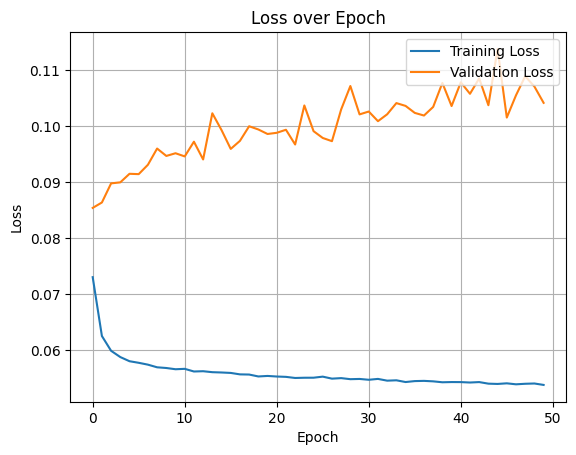

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title('Loss over Epoch')

# 显示图形
plt.show()


In [11]:
true_list = []
pred_list = []
with torch.no_grad():
    for tests, labels in test_loader:
        tests, labels = tests.to(device), labels.to(device)
        outputs = model(tests)
        true_list.extend(labels.cpu().numpy())
        pred_list.extend(outputs.cpu().numpy())

true = np.array([x for x in true_list])
predic = np.array([x for x in pred_list])

In [12]:
index = 3 # 0 1 2 3
mae = mean_absolute_error(true[:,index], predic[:,index])
mse = mean_squared_error(true[:,index], predic[:,index])
rmse = mean_squared_error(true[:,index], predic[:,index], squared=False)
r2 = r2_score(true[:,index], predic[:,index])
mape = mean_absolute_percentage_error(true[:,index], predic[:,index])
item={'BaslineName':'RESNET','MAE':mae,'MSE':mse,'RMSE':rmse,'R2':r2,'MAPE':mape}
print(item)

{'BaslineName': 'RESNET', 'MAE': 0.27322817, 'MSE': 0.10747322, 'RMSE': 0.3278311, 'R2': -0.5936850506068292, 'MAPE': 601136900000.0}


In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')
# 生成数据
plt.figure(figsize=(8, 6))
x = train_dataset.scaler.inverse_transform(true.reshape(-1, 1)).flatten()
y = train_dataset.scaler.inverse_transform(predic.reshape(-1, 1)).flatten()
# 回归分析
coef = np.polyfit(x, y, 1)
fit_fn = np.poly1d(coef)
y_fit = fit_fn(x)
# 绘图
plt.scatter(x, y, label='Data')
plt.plot(x, y_fit, 'black',lw=1, label='Fit')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('GroundTruth',fontsize=20)
plt.ylabel('Predict',fontsize=20)
plt.legend(fontsize=24)
plt.show()

AttributeError: 'MyDataset' object has no attribute 'scaler'

<Figure size 800x600 with 0 Axes>